In [35]:
# OBJETIVO DO NOTEBOOK
# 1º Normalizar dados numéricos e categóricos
# 2º Calibrar o número de grupos para o cluster (Otimização)
# 3º Treinar o modelo de cluster
# 4º Descrever os grupos de modelo de cruster (Centróides)
# 5º Definir a qual grupo uma nova intacia pertence

######################################################
# EXEMPLO DE NORMALIZAÇÃO
# Data Since: 07/03/2023
# @Autor: João Vitor Santian

!python.exe -m pip install --upgrade pip

!pip install pandas==1.5.2

!pip install matplotlib

!pip install scikit-learn

In [36]:
import pandas as pd

# Lê um arquivo CSV com cabeçalho
dataframe = pd.read_csv('dados/dados_normalizar.csv')

# Imprime as primeiras 5 linhas do arquivo
dataframe.head()

,idade;altura;Peso;sexo
0,48;1;107;F
1,10;1;240;F
2,79;1;68;F
3,42;1;160;F
4,23;2;157;F


In [37]:
import pandas as pd
dataframe = pd.read_csv('dados/dados_normalizar.csv', sep=';')
dataframe['sexo'].value_counts()

F    100
M    100
Name: sexo, dtype: int64

In [38]:
# Normalizar os atributos numéricos
dataframe['New columns'] = 0 # Criação da new column
dataframe['n_idade'] = ( dataframe['idade'] - dataframe['idade'].min() ) / ( dataframe['idade'].max() - dataframe['idade'].min() ) # Normalizar usando a equação min/max
dataframe[['idade','n_idade']]

#Normalizar usando biblioteca pronta

# Passo 1: Instalar a lib para normalização
from sklearn import preprocessing # Biblioteca com preprocessadores
normalizador = preprocessing.MinMaxScaler()

#Passo 2: Segmentar a base, separando os atributos numéricos
dados_num = dataframe.drop(columns  = ['sexo', 'n_idade','New columns'])

#Passo 3: Obter o modelo normalizador e salvar para uso posterior
modelo_normalizador = normalizador.fit(dados_num) # O método fit é responsável por obter o modelo que normalizará a base 
dados_num_normalizado = normalizador.fit_transform(dados_num) # Responsável por aplicar a normalização

#alternativa
dados_num_normalizado = modelo_normalizador.fit_transform(dados_num)

#Salvar o modelo normalizador em disco
from pickle import dump, load
dump(modelo_normalizador,open('clusters/normalizador1.model','wb'))

dados_num_normalizado

array([[0.47474747, 0.        , 0.43265306],
       [0.09090909, 0.        , 0.9755102 ],
       [0.78787879, 0.        , 0.27346939],
       [0.41414141, 0.        , 0.64897959],
       [0.22222222, 1.        , 0.63673469],
       [0.27272727, 1.        , 0.4       ],
       [0.71717172, 0.        , 0.34693878],
       [0.60606061, 1.        , 0.30204082],
       [0.62626263, 1.        , 0.27346939],
       [0.75757576, 0.        , 0.28979592],
       [0.44444444, 0.        , 0.9755102 ],
       [0.3030303 , 0.        , 0.13469388],
       [0.22222222, 0.        , 0.99183673],
       [0.4040404 , 1.        , 0.69387755],
       [0.21212121, 1.        , 0.88979592],
       [0.58585859, 0.        , 0.65714286],
       [0.07070707, 0.        , 0.80408163],
       [0.72727273, 1.        , 0.65714286],
       [0.55555556, 0.        , 0.88571429],
       [0.28282828, 0.        , 0.13877551],
       [0.09090909, 0.        , 0.04489796],
       [0.50505051, 0.        , 0.26938776],
       [0.

In [39]:
from pandas.core.arrays.sparse import dtype
# Normalizar dados categoricos

# Passo 1: Segmentar somente os dados categóricos

dados_cat = dataframe[['sexo']]

# Passo 2: Normlizar com get_dummies() do pandas

dados_cat_normalizado = pd.get_dummies(dados_cat)

In [40]:
# Remontar o data frame

# Reconstruir o data frame com os dados numéricos normalizados 
dados_num = pd.DataFrame(dados_num_normalizado, columns = dados_num.columns)

# Juntar com os dados categoricos normalizados
dataframe = dados_num.join(dados_cat_normalizado,how='left')
dataframe

,idade,altura,Peso,sexo_F,sexo_M
0,0.474747,0.0,0.432653,1,0
1,0.090909,0.0,0.975510,1,0
2,0.787879,0.0,0.273469,1,0
3,0.414141,0.0,0.648980,1,0
4,0.222222,1.0,0.636735,1,0
...,...,...,...,...,...
195,0.888889,1.0,0.257143,0,1
196,0.141414,0.0,0.195918,0,1
197,0.676768,0.0,0.567347,1,0
198,0.111111,0.0,0.914286,0,1


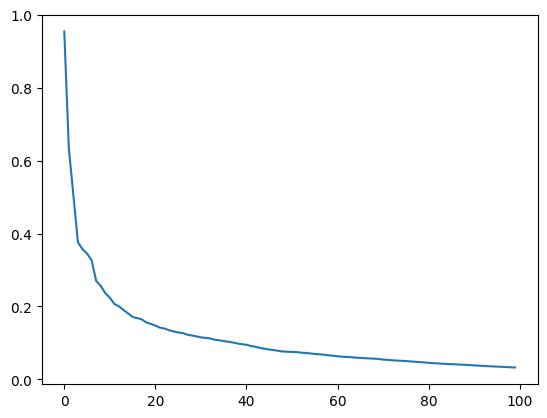

In [41]:
# CALIBRAÇÃO DO CLUSTER
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import numpy as np
distorcoes = []
K = range(1,101)
for k in K: 
  modelo = KMeans(n_clusters=k,random_state=42,n_init='auto').fit(dataframe)
  distorcoes.append(sum(np.min(cdist(dataframe, modelo.cluster_centers_, 'euclidean'), axis=1)) / dataframe.shape[0])
  
plt.plot(distorcoes)

In [42]:
import math
x0 = K[0]
y0 = distorcoes[0]

x1 = K[len(K)- 1]
y1 = distorcoes[len(distorcoes)-1]

distancias = []
for i in range(len(distorcoes)):
  x = K[i]
  y = distorcoes[i]
  numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
  denominador = math.sqrt((y1-y0)**2 + (x1-x0)**2)
  distancias.append(numerador/denominador)

n_clusters_otimo = K[distancias.index(np.max(distancias))]
print('Numero ideal de clusters:', K[distancias.index(np.max(distancias))])

Numero ideal de clusters: 12


In [43]:
#Treinar o modelo definitivo
from pickle import dump
modelo = KMeans(n_clusters=n_clusters_otimo,random_state=42,n_init='auto').fit(dataframe)

dump(modelo,open('clusters/cluster1.modelo','wb'))

In [44]:
dados_num_desnormalizados = modelo_normalizador.inverse_transform(dados_num_normalizado)
dados_num_desnormalizados_DF = pd.DataFrame(dados_num_desnormalizados, columns= dados_num.columns)
dados_num_desnormalizados_DF.head()

,idade,altura,Peso
0,48.0,1.0,107.0
1,10.0,1.0,240.0
2,79.0,1.0,68.0
3,42.0,1.0,160.0
4,23.0,2.0,157.0


In [45]:
dados_cat_normalizado.columns[0].split('_')[1]
# dados_cat_normalizado


'F'

In [46]:
dados_num_desnormalizados_DF['Sexo']= ''
dados_num_desnormalizados_DF['Sexo'] = dados_cat_normalizado.apply(lambda row: 'F' if row['sexo_F'] > row['sexo_M'] else 'M', axis=1)
dados_num_desnormalizados_DF

,idade,altura,Peso,Sexo
0,48.0,1.0,107.0,F
1,10.0,1.0,240.0,F
2,79.0,1.0,68.0,F
3,42.0,1.0,160.0,F
4,23.0,2.0,157.0,F
...,...,...,...,...
195,89.0,2.0,64.0,M
196,15.0,1.0,49.0,M
197,68.0,1.0,140.0,F
198,12.0,1.0,225.0,M


In [47]:
# Cria um dataframe com os novos dados
novos_dados = pd.DataFrame({
    'idade':  [20, 19, 14],
    'altura': [1, 2, 1],
    'Peso':   [65, 80, 70],
    'sexo':   ['M', 'F', 'M']
})

# Normaliza os atributos numéricos dos novos dados
novos_dados['idade'] = (novos_dados['idade'] - novos_dados['idade'].min()) / (novos_dados['idade'].max() - novos_dados['idade'].min())

# Segmenta os dados categóricos dos novos dados
novos_dados_cat = novos_dados[['sexo']]

# Normaliza os dados categóricos dos novos dados
novos_dados_cat_norm = pd.get_dummies(novos_dados_cat)

# Remove a coluna 'sexo' dos novos dados
novos_dados_norm = novos_dados.drop('sexo', axis=1)

# Normaliza todos os atributos dos novos dados
novos_dados_norm = pd.DataFrame(normalizador.transform(novos_dados_norm), columns=novos_dados_norm.columns)

# Junta os dados numéricos e categóricos normalizados
novos_dados_norm = novos_dados_norm.join(novos_dados_cat_norm)

# Preenche as colunas não existentes com zeros
novos_dados_norm = novos_dados_norm.fillna(0)

novos_dados_norm

,idade,altura,Peso,sexo_F,sexo_M
0,0.000000,0.0,0.261224,0,1
1,-0.001684,1.0,0.322449,1,0
2,-0.010101,0.0,0.281633,0,1


In [48]:
# Carrega o modelo treinado
modelo_cluster = load(open('clusters/cluster1.model', 'rb'))

# Remove as colunas 'sexo_F' e 'sexo_M' dos novos dados normalizados
novos_dados_normalizados = novos_dados_norm.drop(columns=['sexo_F', 'sexo_M'])

# Desnormaliza os dados numéricos dos novos dados
novos_dados_desnorm = modelo_normalizador.inverse_transform(novos_dados_normalizados)
novos_dados_desnorm_DF = pd.DataFrame(novos_dados_desnorm, columns=novos_dados_normalizados.columns)

# Adiciona a coluna 'sexo' aos novos dados desnormalizados
novos_dados_desnorm = pd.DataFrame(novos_dados_desnorm, columns=novos_dados_normalizados.columns)
novos_dados_desnorm = pd.concat([novos_dados_desnorm, novos_dados['sexo']], axis=1)

# Previsão dos clusters dos novos dados normalizados
novos_dados_cluster = modelo_cluster.predict(novos_dados_norm)

# Adiciona a coluna de clusters ao dataframe dos novos dados desnormalizados
novos_dados_desnorm['cluster'] = novos_dados_cluster

# Salva os novos dados desnormalizados com os clusters em um arquivo CSV
novos_dados_desnorm.to_csv('dados/novos_dados_com_clusters.csv', index=False)

# Imprime os novos dados desnormalizados com seus respectivos clusters
print(novos_dados_desnorm)


      idade  altura  Peso sexo  cluster
0  1.000000     1.0  65.0    M        5
1  0.833333     2.0  80.0    F        2
2  0.000000     1.0  70.0    M        5
